# Принятие решений в бизнесе

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

## Оглавление

1. Изучение данных из файла
2. Приоритизация гипотез
3. Анализ A/B-теста
4. Общий вывод

##  1. Изучение данных из файла 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
register_matplotlib_converters()

In [2]:
# База по гипотезам
hypothesis_data = pd.read_csv('/datasets/hypothesis.csv')
# Привел названия столбцов к нижнему регистру
hypothesis_data.columns = hypothesis_data.columns.str.lower()
# База по заказам
orders_data = pd.read_csv('/datasets/orders.csv')
orders_data.rename(
    columns = {'transactionId' : 'transaction_id', 
    'visitorId' : 'visitor_id'}, inplace = True)
# База по пользователям
visitors_data = pd.read_csv('/datasets/visitors.csv')
display(hypothesis_data.head())
hypothesis_data.info()
display(orders_data.head())
orders_data.info()
display(visitors_data.head())
visitors_data.info()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [3]:
# Проверяю наличие пропусков
print('Пропуски в hypothesis_data:', hypothesis_data.isna().sum())
print('Пропуски в orders_data:', orders_data.isna().sum())
print('Пропуски в visitors_data:', visitors_data.isna().sum())
# Проверяю наличие дубликатов
print('Количество дубликатов в hypothesis_data:', hypothesis_data.duplicated().sum())
print('Количество дубликатов в orders_data:', orders_data.duplicated().sum())
print('Количество дубликатов в visitors_data:', visitors_data.duplicated().sum())

Пропуски в hypothesis_data: hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64
Пропуски в orders_data: transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64
Пропуски в visitors_data: date        0
group       0
visitors    0
dtype: int64
Количество дубликатов в hypothesis_data: 0
Количество дубликатов в orders_data: 0
Количество дубликатов в visitors_data: 0


**Вывод**

Всего 3 таблицы, типы данных - int64, object.

Количество значений в столбцах не различается. Пропусков нет, дубликатов не обнаружил.

Привёл названия столбцов в hypothesis_data к нижнему регистру. Названия столбцов в orders_data изменил, согласно змеиному регистру.

Согласно документации к данным:

Таблица hypothesis (информация о гипотезах):

* `hypothesis` — краткое описание гипотезы;
* `reach` — охват пользователей по 10-балльной шкале;
* `impact` — влияние на пользователей по 10-балльной шкале;
* `confidence` — уверенность в гипотезе по 10-балльной шкале;
* `efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Таблица orders (информация о заказах):

* `transaction_id` — идентификатор заказа;
* `visitor_id` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Таблица visitors (информация о пользователях):

* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

##  2. Приоритизация гипотез 

In [4]:
# ICE для гипотез
hypothesis_data['ICE'] = ((hypothesis_data['impact'] * hypothesis_data['confidence']) / hypothesis_data['efforts'])
display(hypothesis_data[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


Перспективные гипотезы: 8, 0, 7, 6 и 2.

In [5]:
# RICE для гипотез
hypothesis_data['RICE'] = (
    (hypothesis_data['reach'] * hypothesis_data['impact'] * hypothesis_data['confidence'])
    / hypothesis_data['efforts']) 
display(hypothesis_data[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Перспективные гипотезы: 7, 2, 0, 6 и 8.

**Вывод**

1. Способ приоритизации задач ICE показывает, что самые перспективные гипотезы: 8, 0, 7, 6 и 2.
2. RICE показывает, что наиболее перспективные гипотезы: 7, 2, 0, 6 и 8.
3. Оба способа показывают одинаковые гипотезы, однако в разном порядке. На первом месте по ICE гипотеза под номером 8, по RICE лидирующую позицию занимает номер 7, а гипотеза под номером 8 в самом конце. Так получилось, потому что у 7 высокий параметр "reach" (скольких пользователей затронет изменение). Также высокий показатель охвата пользователей у гипотез 2 и 3, но у 3 номера низкие остальные параметры, поэтому он менее перпективен.       

##  3. Анализ A/B-теста 

In [6]:
orders_data['date'] = orders_data['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors_data['date'] = visitors_data['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
dates_groups = orders_data[['date', 'group']].drop_duplicates()
orders_aggregated = dates_groups.apply(
    lambda x: orders_data[
        np.logical_and(
            orders_data['date'] <= x['date'], orders_data['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
visitors_aggregated = dates_groups.apply(
    lambda x: visitors_data[
        np.logical_and(
            visitors_data['date'] <= x['date'], visitors_data['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

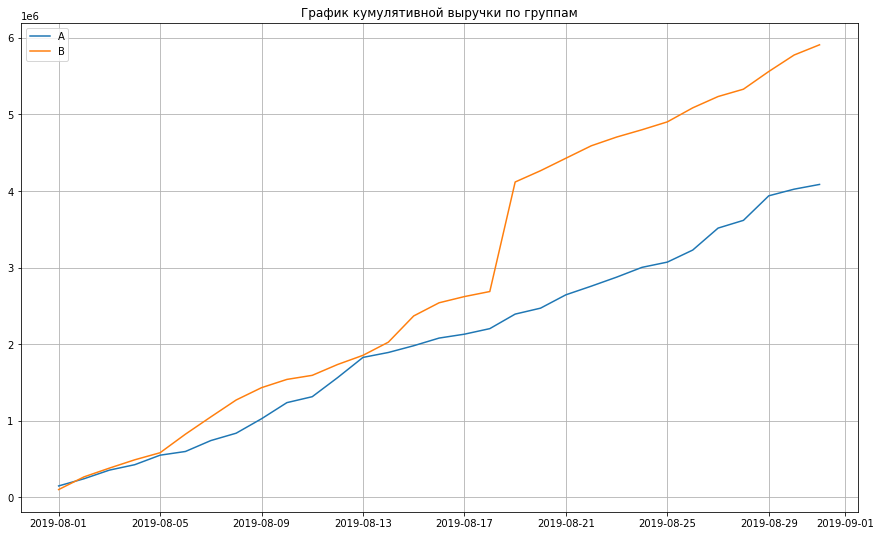

In [7]:
# График кумулятивной выручки по группам
plt.figure(figsize = (15, 9))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.grid()
plt.legend()
plt.show()

На графике видно, что сегмент "В" преобладает над "A". До 18 августа они были практически наравне, но потом произошел резкий скачок у сегмента "B". Возможно на результат повлияли аномально большие заказы.

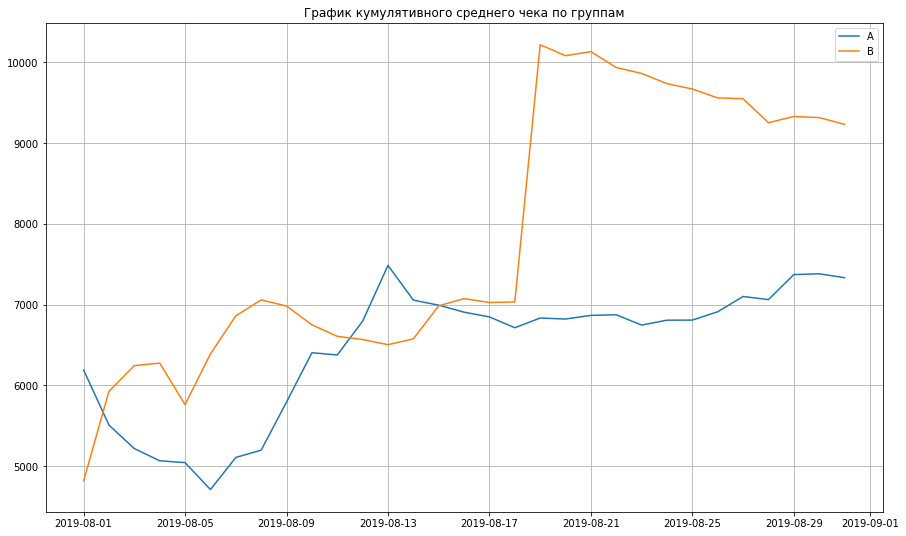

In [8]:
# График кумулятивного среднего чека по группам
plt.figure(figsize = (15, 9))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.grid()
plt.legend()
plt.show()

Группа "В" сильно обходит "А". Значение кумулятивного среднего чека по сегментам колеблется, также наблюдается скачок 18 августа у "В". Возможно требуется провести дополнительный анализ выбросов.

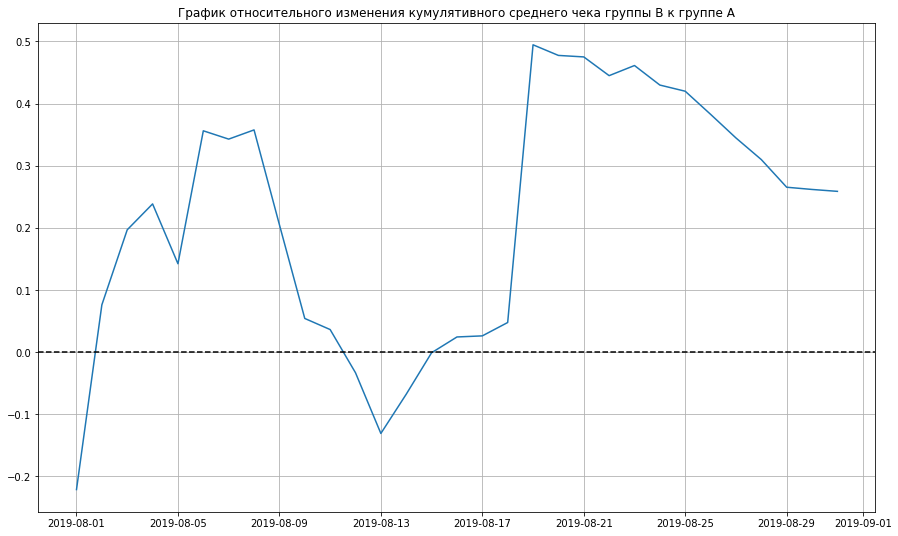

In [9]:
# График относительного изменения кумулятивного среднего чека группы B к группе A
merged_сumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date',
                                                       right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize = (15, 9))
plt.plot(merged_сumulative_revenue['date'], (merged_сumulative_revenue['revenueB']
                    /merged_сumulative_revenue['ordersB'])/(merged_сumulative_revenue['revenueA']
                                                    /merged_сumulative_revenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.grid()
plt.show()

Данный график также показывает, резкий скачок 18 августа. 

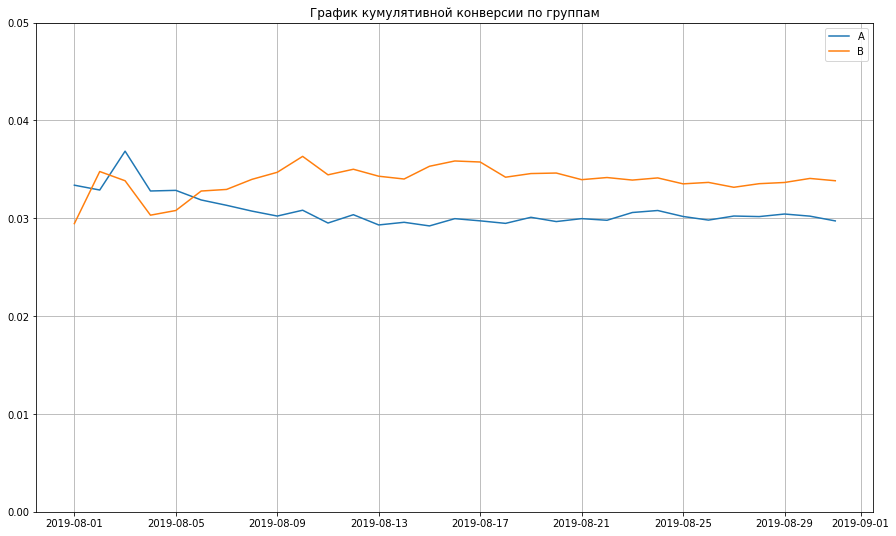

In [10]:
# График кумулятивной конверсии по группам
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']
plt.figure(figsize = (15, 9))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.grid()
plt.ylim(0, 0.05)
plt.legend()
plt.show()

В начале теста группа "А" имела большую конверсию, но постепенно группа "В" выровнялась и зафиксировалась около одного значения, больше значения группы "А".

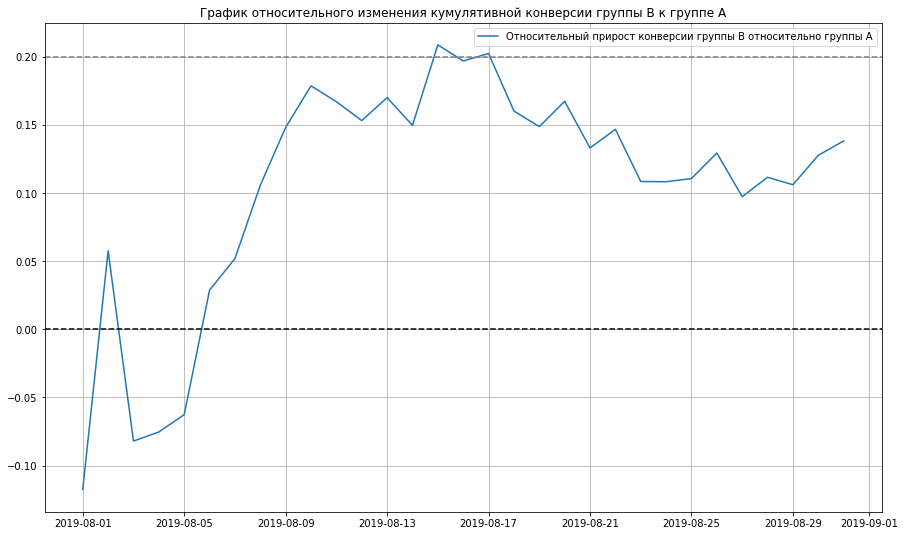

In [11]:
# График относительного изменения кумулятивной конверсии группы B к группе A
merged_сumulative_сonversions = cumulative_data_A[['date','conversion']].merge(
    cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize = (15, 9))
plt.plot(merged_сumulative_сonversions['date'],
         merged_сumulative_сonversions['conversionB']
         /merged_сumulative_сonversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.show()

Начиная с 6 августа, накопительная конверсия сегмента "B" лежит значительно выше накопительной конверсии сегмента "A".

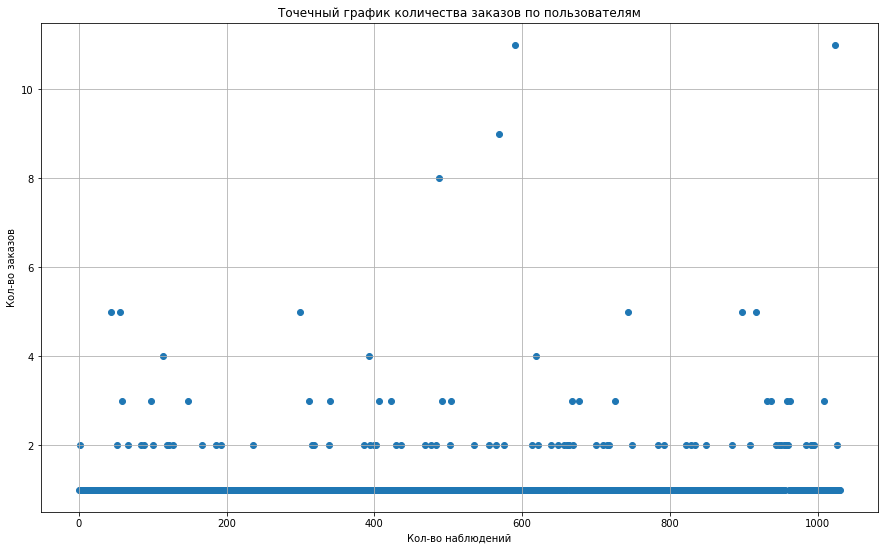

In [12]:
# База по пользователям
orders_by_users = (
    orders_data.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users.columns = ['visitor_id', 'orders']
# Точечный график количества заказов по пользователям
plt.figure(figsize = (15, 9))
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Кол-во наблюдений')
plt.ylabel('Кол-во заказов')
plt.grid()
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'])
plt.show()

В основном пользователи делают 1 заказ, меньшее кол-во пользователей делают 2 заказа, однако их не мало. 3 и более заказов редкость. Для более точного анализа нужно посчитать выборочные перцентили.

In [13]:
# Перцентили
print(np.percentile(orders_by_users['orders'], [90, 95, 99]))

[1. 2. 4.]


Не более 5% пользователей совершили больше двух заказов, не более 1% больше четырех.  Граница для определения аномальных пользователей по количеству заказов - не более 2.

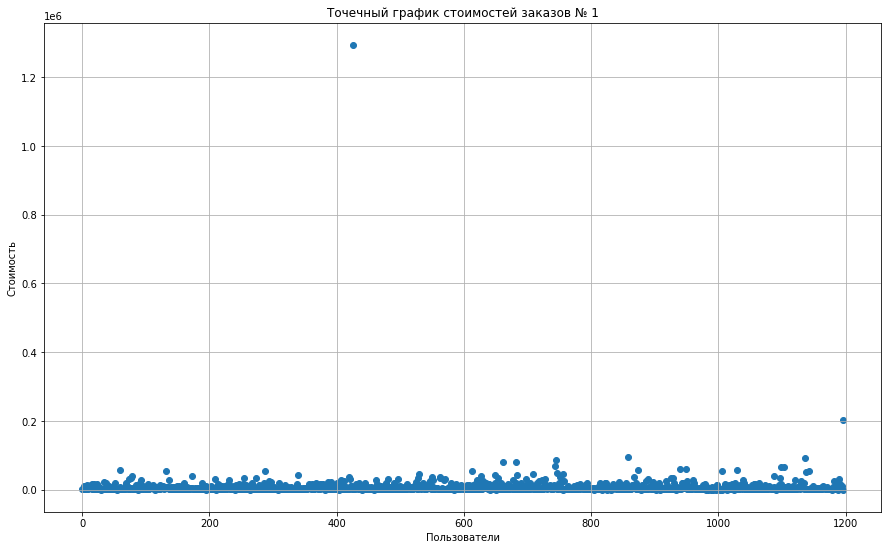

In [14]:
# Точечный график стоимостей заказов № 1
plt.figure(figsize = (15, 9))
plt.title('Точечный график стоимостей заказов № 1')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость')
plt.grid()
x_values = pd.Series(range(0, len(orders_data['revenue'])))
plt.scatter(x_values, orders_data['revenue'])
plt.show()

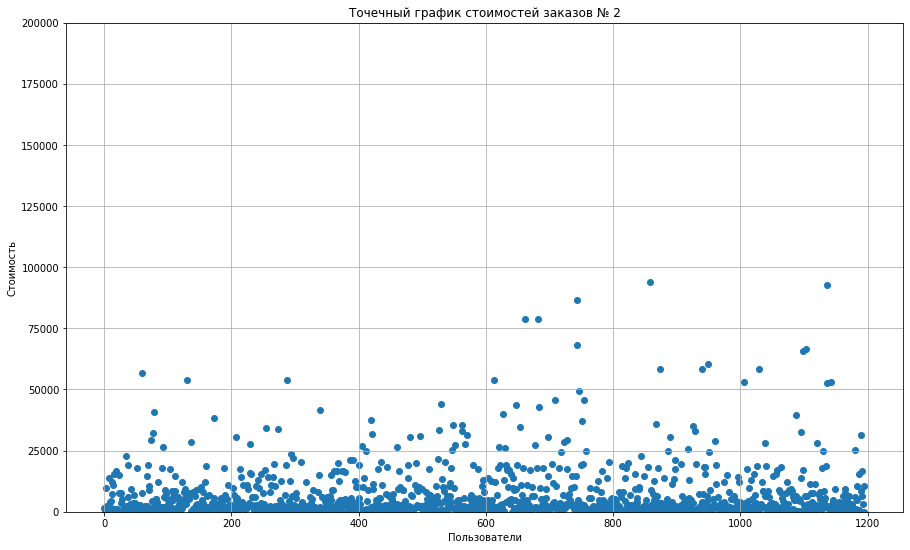

In [15]:
# Точечный график стоимостей заказов № 2
plt.figure(figsize = (15, 9))
plt.title('Точечный график стоимостей заказов № 2')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость')
plt.grid()
plt.ylim(0, 200000)
x_values = pd.Series(range(0, len(orders_data['revenue'])))
plt.scatter(x_values, orders_data['revenue'])
plt.show()

На первом графике стоимостей заказов наблюдается огромный выброс на одного пользователя со стоимость заказа в 1.20 млн. На втором графике установлено ограничение по оси Y на 200 000, на нем видно, что в основном пользователи заказывают до 25 тысяч. 
Для более точного анализа нужно посчитать выборочные перцентили.

In [16]:
# Перцентили
print(np.percentile(orders_data['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


Не более, чем у 5% заказов чек дороже 28 000, не более 1% дороже 58233. Граница для определения аномальных пользователей по стоимости заказов - не более 28000.

In [17]:
# Cтатистическая значимость различий в конверсии между группами по «сырым» данным
visitors_A_daily = visitors_data[visitors_data['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']
visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']
visitors_B_daily = visitors_data[visitors_data['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']
visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B'] 
orders_A_daily = (
    orders_data[orders_data['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']
orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_A_cummulative.columns = [
    'date',
    'orders_cummulative_A',
    'revenue_cummulative_A',
] 
orders_B_daily = (
    orders_data[orders_data['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']
orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_B_cummulative.columns = [
    'date',
    'orders_cummulative_B',
    'revenue_cummulative_B',
] 
raw_data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
) 
orders_by_users_A = (
    orders_data[orders_data['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['visitor_id', 'orders']
orders_by_users_B = (
    orders_data[orders_data['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['visitor_id', 'orders'] 
sample_A = pd.concat(
    [
        orders_by_users_A['orders'],
        pd.Series(
            0,
            index=np.arange(
                raw_data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sample_B = pd.concat(
    [
        orders_by_users_B['orders'],
        pd.Series(
            0,
            index=np.arange(
                raw_data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print("{0:.5f}".format(st.mannwhitneyu(sample_A, sample_B)[1]))
print("{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

0.01679
0.138


Нулевая гипотеза – конверсии в группах "А" и "В" равны, параметры равны. Альтернативная гипотеза – конверсии в группах "А" и "В" не равны, параметры не равны. H₀ всегда формулируется так, чтобы использовать знак равенства. 

P-value меньше 0,05, поэтому нулевую гипотезу отвергаем. Анализ "сырых данных" сообщает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы "В" к конверсии группы "А" равен 13,8%.

In [18]:
# Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным
print('{0:.3f}'.format(st.mannwhitneyu(
    orders_data[orders_data['group']=='A']['revenue'], orders_data[orders_data['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(
    orders_data[orders_data['group']=='B']['revenue'].mean()/orders_data[orders_data['group']=='A']['revenue'].mean()-1))

0.729
0.259


Нулевая гипотеза – средние чеки в группах "А" и "В" равны, параметры равны. Альтернативная гипотеза – средние чеки в группах "А" и "В" не равны, параметры не равны. 

P-value больше 0,05, отвергнуть нулевую гипотезу не получилось. Анализ "сырых данных" сообщает, что в средних чеках между группами нет статистически значимых различий. Относительное различие среднего чека между сегментами 25,9%.

In [19]:
# Cтатистическая значимость различий в конверсии между группами по «очищенным» данным
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 2]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders_data[orders_data['revenue'] > 28000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                raw_data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                raw_data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('{0:.5f}'.format(st.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print('{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))

0.01304
0.173


P-value меньше 0,05, поэтому нулевую гипотезу отвергаем. Анализ "очищенных данных" сообщает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы "В" к конверсии группы "А" равен 17,3%.

In [20]:
# Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders_data[
                np.logical_and(
                    orders_data['group'] == 'A',
                    np.logical_not(orders_data['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders_data[
                np.logical_and(
                    orders_data['group'] == 'B',
                    np.logical_not(orders_data['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)
print(
    "{0:.3f}".format(
        orders_data[
            np.logical_and(
                orders_data['group'] == 'B',
                np.logical_not(orders_data['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders_data[
            np.logical_and(
                orders_data['group'] == 'A',
                np.logical_not(orders_data['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.738
-0.020


P-value больше 0,05, отвергнуть нулевую гипотезу не получилось. Анализ "очищенных данных" сообщает, что в средних чеках между группами нет статистически значимых различий. Относительное различие среднего чека между сегментами -2%, т.е. средний чек группы "А" выше, чем у "В".

**Вывод**

1. Исходя из всех построенных графиков, можно сделать вывод, что сегмент "В" преобладает над "А". Также удалось установить, что есть выбросы в данных. 
2. В конверсии между группами "А" и "В" есть статистически значимые различия как по "сырым данным", так и по "очищенным". P-value меньше 0,05, поэтому нулевую гипотезу о том, что параметры равны, отвергаем.
3. По средним чекам между группами "А" и "В" нет статистически значимых различий как по "сырым данным", так и по "очищенным". P-value больше 0,05, отвергнуть нулевую гипотезу не получилось.
4. Для проведения анализа выбрал непараметрический тест Уилкоксона-Манна-Уитни, из-за выбросов в данных.

## 4. Общий вывод 

По данным интернет-магазина, можно сделать несколько выводов:
1. Способ приоритизации задач ICE показывает, что самые перспективные гипотезы: 8, 0, 7, 6 и 2. RICE показывает, что наиболее перспективные гипотезы: 7, 2, 0, 6 и 8. Оба способа показывают одинаковые гипотезы, однако в разном порядке. На первом месте по ICE гипотеза под номером 8, по RICE лидирующую позицию занимает номер 7, а гипотеза под номером 8 в самом конце. Так получилось, потому что у 7 высокий параметр "reach" (скольких пользователей затронет изменение).
2. Сравнивая группы "В" и "А", становится понятно, что сегмент "В" лучше. Конверсия у него выше, чем у "А", а средний чек не имеет статистически значимых различий между группами. В связи с этим, рекомендую остановить тест, зафиксировать победу группы "В".     